<a href="https://colab.research.google.com/github/alexfok/IntroDeepLearning2022/blob/main/Assignment3_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alexander Fok 308669944

Avi Dvir 204423735

Gal Cohen 204675805

# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Run NN and torch data on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Notebook Control variables
# Print DEBUG info
DEBUG = False
# Variable controlling debug prints while training\infering with NN
DEBUG_NN = False
# Create the data sets or load the preloaded np arrays
CREATE_DATA = True
# Path to save the created numpy arrays
array_save_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/ex3/data.npy'
# Path to load the created numpy arrays
array_load_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/ex3/data.npy.npz'
best_model_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/models_chackpoints/ChannelsCNN/model_chkpt_epoch_20.pk'
checkpoint_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/models_chackpoints/ChannelsCNN/model_chkpt_epoch_{}.pk'

# Raw data set paths
path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/train/*.*"
path_test_m = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_m/*.*"
path_test_w = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_w/*.*"


## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [3]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob
from tqdm import tqdm

# Save numpy arrays
def save_numpy_arrays(array_save_path, train_data, test_w_data, test_m_data):
  np.savez(array_save_path, train_data = train_data, test_m_data = test_m_data, test_w_data = test_w_data)

# Load numpy arrays
def load_numpy_arrays(array_load_path):
  train_data = None
  test_m_data = None
  test_w_data = None
  data = np.load(array_load_path, allow_pickle = True)
  train_data = data['train_data']
  test_m_data = data['test_m_data']
  test_w_data = data['test_m_data']
  if DEBUG:
    print(f'data.files {data.files}')
    print(f'train_data.shape {train_data.shape}')
    print(f'test_w_data.shape {test_w_data.shape}')
    print(f'test_m_data.shape {test_m_data.shape}')
  return train_data, test_w_data, test_m_data


# Load images to numpy arrays
def load_images(path):
  images = dict()
  # find number of unique persons in data set
  person_index = -1
  active_person = None
  for file in tqdm(sorted(glob.glob(path))):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    person_n, shoe, leg, _ = filename.split("_")
    if active_person != person_n: # Increment person index each time new person detected
      person_index += 1
      active_person = person_n
    if DEBUG:
      print(f'person_index: {person_index} active_person: {active_person} person_n: {person_n}')
  print(f'Total person_index: {person_index}')

  # Allocate the np array according to found number of unique persons in data set
  train_data_np = np.empty((person_index+1, 3, 2, 224, 224, 3))
  person_index = -1
  active_person = None
  for file in tqdm(sorted(glob.glob(path))):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images[filename] = img[:, :, :3] # remove the alpha channel

    person_n, shoe, leg, _ = filename.split("_")
    if active_person != person_n: # Increment person index each time new person detected
      person_index += 1
      active_person = person_n
    if DEBUG:
      print(f'person_index: {person_index} active_person: {active_person} person_n: {person_n}')
    shoe_n = int(shoe)
    shoe_n -= 1                     # Start shoe index from 0
    leg = 1 if leg == 'right' else 0
    train_data_np[person_index, shoe_n, leg,:,:,:] = images[filename]
  return train_data_np

def create_and_save_data(array_save_path):
  # Load images for train, test_w and test_m data sets
  train_data = load_images(path_train)
  test_w_data = load_images(path_test_w)
  test_m_data = load_images(path_test_m)

  # Process the loaded data
  # Divide data by 255
  train_data /= 255.0
  test_w_data /= 255.0
  test_m_data /= 255.0

  # Subtract 0.5
  train_data -= 0.5
  test_w_data -= 0.5
  test_m_data -= 0.5

  # Save the data sets for future use
  save_numpy_arrays(array_save_path, train_data, test_w_data, test_m_data)
  return train_data, test_w_data, test_m_data

if DEBUG:
  sample_image = train_data_np[0,0,0,:,:,:]
  plt.figure()
  plt.imshow(sample_image)
  images[4,0,0,:,:,:]

In [4]:
# These data sets will be initialized at the end of this cell
train_data = None
test_m_data = None
test_w_data = None
valid_set = None
train_set = None

if CREATE_DATA:
  # Create and save data sets
  print('Create numpy arrays from raw data sets and save to GDrive')
  train_data, test_w_data, test_m_data = create_and_save_data(array_save_path)
else:
  print('Load the numpy arrays from GDrive')
  # Load the data files and initiate global variables:
  # train_data, test_m_data, test_w_data, valid_set, train_set
  # Verify that data file exists
  # !ls -la '/content/gdrive/My Drive/IntroDeepLearning2022Data/ex3'
  train_data, test_w_data, test_m_data = load_numpy_arrays(array_load_path)
  # Split training data to training and validation

# Split the train data to train (80%) and validation (20%) data sets
split_idx = int(train_data.shape[0]/5)
print(f'train_data.shape: {train_data.shape}, split_idx: {split_idx}')
valid_set, train_set = train_data[:split_idx], train_data[split_idx:]
print(f'valid_set.shape: {valid_set.shape}, train_set.shape: {train_set.shape}')
#print(train_data)
#print(test_m_data)
#print(test_w_data)
#print(valid_set)
#print(train_set)



Create numpy arrays from raw data sets and save to GDrive


100%|██████████| 678/678 [00:00<00:00, 808339.43it/s]


Total person_index: 112


100%|██████████| 60/60 [00:00<00:00, 411879.28it/s]


Total person_index: 9


100%|██████████| 60/60 [00:00<00:00, 176726.29it/s]


Total person_index: 9


100%|██████████| 60/60 [00:09<00:00,  6.12it/s]


train_data.shape: (113, 3, 2, 224, 224, 3), split_idx: 22
valid_set.shape: (22, 3, 2, 224, 224, 3), train_set.shape: (91, 3, 2, 224, 224, 3)


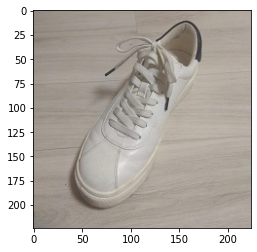

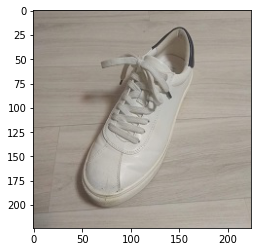

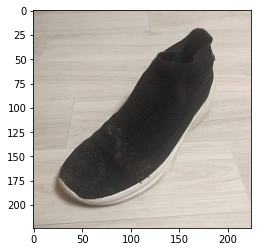

In [5]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+ 0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+ 0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+ 0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(113, 3, 2, 224, 224, 3)
(339, 448, 224, 3)


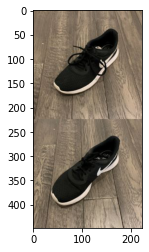

In [6]:
# Your code goes here
def generate_same_pair(data):
  paired_data = []
  for person in data:
    for pair in person:
      paired_data.append(cv2.vconcat(pair))
  return np.array(paired_data)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0] + 0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(113, 3, 2, 224, 224, 3)
(339, 448, 224, 3)


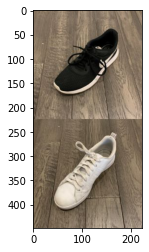

In [7]:
# Your code goes here
def generate_different_pair(data):
  paired_data = []
  for person in data:
      paired_data.append(cv2.vconcat([person[0,0], person[1,1]]))
      paired_data.append(cv2.vconcat([person[2,1], person[1,0]]))
      paired_data.append(cv2.vconcat([person[2,0], person[0,1]]))
  return np.array(paired_data)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0] + 0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**
Different shoes from the same pair have similar properties - for example the same size. We want to train a model that determines whether two shoes come from the same pair or different pairs of the same person.
In addition, the same person captures his pictures using the same background and same angle view, thus our model would only need to concentrate on the object and less computation efforts to learn the background.


### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**
In case of unbalanced training data set, it can happen that the training will be baised to the samples with larger distribution. In the above example, the trained model might perform badly if requested to identify shoes from the same pair.
When our data is not balanced, we inherently intreduce a bias into our model. Since same pairs are statistically
rare in our dataset, the model would see unbalanced pair most of the time and thus by just yielding 'different
pair' it can get a 99% accuracy without actually learning the task we wanted it to do, and would have a poor
performance during test.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [8]:
class CNN(nn.Module):
    def __init__(self, n=4, kernel_size=5, stride=2, input_shape=(3, 448, 224)):
      super(CNN, self).__init__()
      # TODO: complete this method
      padding_num = int((kernel_size-1)/2)
      self.padding = (padding_num, padding_num)
      self.C, self.H, self.W = input_shape

      self.cnn1 = torch.nn.Conv2d(in_channels=self.C, out_channels=n, stride=stride, kernel_size=kernel_size, padding=self.padding)
      self.cnn2 = torch.nn.Conv2d(in_channels=n, out_channels=2*n, stride=stride, kernel_size=kernel_size, padding=self.padding)
      self.cnn3 = torch.nn.Conv2d(in_channels=2*n, out_channels=4*n, stride=stride, kernel_size=kernel_size, padding=self.padding)
      self.cnn4 = torch.nn.Conv2d(in_channels=4*n, out_channels=8*n, stride=stride, kernel_size=kernel_size, padding=self.padding)
      self.flatten = torch.nn.Flatten()
      self.le_relu = torch.nn.LeakyReLU(0.1)
      self.relu = torch.nn.ReLU()
      self.logsoftmax = torch.nn.LogSoftmax(dim=1)

      # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*n channels
      # thus, Linear input shape: (8*n)*((self.H*self.W)/(2**8))
      fc1_inp = int((8*n)*((self.H*self.W)/(2**8)))
      self.fc1 = torch.nn.Linear(in_features=fc1_inp, out_features=100)
      self.fc2 = torch.nn.Linear(in_features=100, out_features=2)

    # TODO: complete this class
    def forward(self, x):
      if DEBUG_NN:
        print(f'in x.shape: {x.shape:}')
      x = self.le_relu(self.cnn1(x))
      x = self.le_relu(self.cnn2(x))
      x = self.le_relu(self.cnn3(x))
      x = self.le_relu(self.cnn4(x))
      x = self.flatten(x)
      y = self.relu(self.fc1(x))
      y = self.fc2(y)
      out = self.logsoftmax(y)
      if DEBUG_NN:
         print(f'log_softmax out.shape: {out.shape:}')
      return out

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [9]:
class CNNChannel(nn.Module):
    def __init__(self, n=4, kernel_size=5, stride=2, input_shape=(6, 224, 224)):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        padding_num = int((kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.cnn1 = torch.nn.Conv2d(in_channels=self.C, out_channels=n, stride=stride, kernel_size=kernel_size, padding=self.padding)  # here in_channels changed to 6
        self.cnn2 = torch.nn.Conv2d(in_channels=n, out_channels=2*n, stride=stride, kernel_size=kernel_size, padding=self.padding)
        self.cnn3 = torch.nn.Conv2d(in_channels=2*n, out_channels=4*n, stride=stride, kernel_size=kernel_size, padding=self.padding)
        self.cnn4 = torch.nn.Conv2d(in_channels=4*n, out_channels=8*n, stride=stride, kernel_size=kernel_size, padding=self.padding)
        self.flatten = torch.nn.Flatten()
        self.le_relu = torch.nn.LeakyReLU(0.1)
        self.relu = torch.nn.ReLU()
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)

        # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*n channels
        # thus, Linear input shape: (8*n)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*n)*((self.H*self.W)/(2**8)))
        self.fc1 = torch.nn.Linear(in_features=fc1_inp, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=2)

    # TODO: complete this class
    def forward(self, x):
      # stack shoe
      if DEBUG_NN:
        print(f'in x.shape: {x.shape:}')
      s1 = x[:, :, :self.H, :]
      s2 = x[:, :, self.H:, :]
      x = torch.cat([s1,s2], dim=1)
      if DEBUG_NN:
        print(f'cat x.shape: {x.shape:}')
      # rest in the same
      x = self.le_relu(self.cnn1(x))
      x = self.le_relu(self.cnn2(x))
      x = self.le_relu(self.cnn3(x))
      x = self.le_relu(self.cnn4(x))
      x = self.flatten(x)
      y = self.relu(self.fc1(x))
      y = self.fc2(y)
      out = self.logsoftmax(y)
      if DEBUG_NN:
        print(f'in out.shape: {out.shape:}')
      return out

In [23]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**
in our opinion the model that will perform better will be CNNChannel
we can see from the image that testing heel feature of the shoe from two images in separated channels will be easier then learning it from pixels feature on the same image\frame
specially when the image taken in the same place ( as we can see on the example photos) - with same environment conditions. 


## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**
in case we want for example to match shoe for a blind person, its important to us to gather the wrong predictions on the negative samples rather than on the positive ones.
it really depend on which application we use our model.
its easy for us to understand whether the model learns successfuly each class features by itself when we separating between false positives and false negatives.
with all the information we gather it will easier for us to identify and solve problem

lets say we have total accuracy of 50% :
in one hand this info let us conclude that one class gets 100% accuracy while the other gets 0% or in the other hand both classes get 50% accuracy.

it will be possible for us to identify a problem without the information about each class accuracy.

In [10]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size])
        # reshape (our modification)
        N, H, W, C = xs.shape
        xs = xs.view(N,C,H,W)

        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size])
        # reshape (our modification)
        N, H, W, C = xs.shape
        xs = xs.view(N,C,H,W)

        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [11]:
# Write your code here
def train_model(model,
                train_data=train_set,
                validation_data=valid_set,
                batch_size=100,
                num_epochs=100,
                learning_rate=0.001,
                weight_decay=0,
                checkpoint_path=None):
  
    # choice of loss function & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    epocs_vec, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg  = [], [] ,[], [], []

    # obtaining the positive and negative samples
    pos_train = generate_same_pair(train_data)
    neg_train = generate_different_pair(train_data)

    # labels (one-hot representation)
    pos_labels = torch.Tensor(np.array([np.eye(2)[1] for _ in range(batch_size // 2)]))  # one_hot(pos = 1) <=> [0,1]
    neg_labels = torch.Tensor(np.array([np.eye(2)[0] for _ in range(batch_size // 2)]))  # one_hot(neg = 0) <=> [1,0]
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    data_size = len(pos_train) + len(neg_train)

    # main training loop
    n = 0 # total number of iterations

    for epoch in range(num_epochs):  # epochs
        for i in range(0, data_size, batch_size):  # iterations in each epoch
           
            if (i + batch_size) > data_size:
                break

            # shuffle data (assume len(pos_train)=len(neg_train))
            reindex = np.random.permutation(len(pos_train))
            pos_train = pos_train[reindex]
            reindex = np.random.permutation(len(pos_train))
            neg_train = neg_train[reindex]

            # create batch
            pos_batch = pos_train[: batch_size // 2]
            neg_batch = neg_train[: batch_size // 2]

            # convert to tensors
            pos_batch = torch.Tensor(pos_batch)
            neg_batch = torch.Tensor(neg_batch)

            # reshape
            N, H, W, C = pos_batch.shape
            pos_batch = pos_batch.view(N,C,H,W)
            neg_batch = neg_batch.view(N,C,H,W)

            # create input tensor
            input_batch = torch.cat([pos_batch, neg_batch], dim=0)

            # train
            optimizer.zero_grad()         # a clean up step for PyTorch
            y = model(input_batch)        # compute prediction logit
            loss = criterion(y, labels)   # compute the total loss
            loss.backward()               # compute updates for each parameter
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            # increment the iteration number
            n += 1


        epocs_vec.append(epoch)
        train_cost = float(loss.detach().numpy())

        pos_acc_train, neg_acc_train = get_accuracy(model, train_data, batch_size=batch_size)
        train_accs_pos.append(pos_acc_train)
        train_accs_neg.append(neg_acc_train)

        pos_acc_val, neg_acc_val = get_accuracy(model, valid_set, batch_size=batch_size)
        val_accs_pos.append(pos_acc_val)
        val_accs_neg.append(neg_acc_val)      
    
        print("Epoch %d, Iter %d. [Val Acc %.0f%% (pos: %.0f%%, neg: %.0f%%)] [Train Acc %.0f%% (pos: %.0f%%, neg: %.0f%%), Loss %f]" % (
              epoch, n, (pos_acc_val + neg_acc_val) * 50, pos_acc_val * 100, neg_acc_val * 100, (pos_acc_train + neg_acc_train) * 50, pos_acc_train * 100, neg_acc_train * 100, train_cost))

        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))

    return iters, losses, epocs_vec, np.array(train_accs_pos), np.array(train_accs_neg), np.array(val_accs_pos), np.array(val_accs_neg)

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [12]:
def plot_learning_curve(iters, losses, epocs_vec, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle("Learning Curve: Accuracy per Epoch")

    axs[0].plot(epocs_vec, train_accs_pos, label="Train")
    axs[0].plot(epocs_vec, val_accs_pos, label="Validation")
    axs[0].set_title('Positive Samples')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    axs[1].plot(epocs_vec, train_accs_neg, label="Train")
    axs[1].plot(epocs_vec, val_accs_neg, label="Validation")
    axs[1].set_title('Negative Samples')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    axs[2].plot(epocs_vec, (train_accs_neg+train_accs_pos)/2, label="Train")
    axs[2].plot(epocs_vec, (val_accs_neg+val_accs_pos)/2, label="Validation")
    axs[2].set_title('Total Accuracy')
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("Accuracy")
    axs[2].legend()
    

=== CNNChannel ===
Epoch 0, Iter 1. [Val Acc 50% (pos: 0%, neg: 100%)] [Train Acc 50% (pos: 0%, neg: 100%), Loss 0.694327]
Epoch 1, Iter 2. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.711187]
Epoch 2, Iter 3. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.692597]
Epoch 3, Iter 4. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.694308]
Epoch 4, Iter 5. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.693905]
Epoch 5, Iter 6. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.696835]
Epoch 6, Iter 7. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.692810]
Epoch 7, Iter 8. [Val Acc 52% (pos: 92%, neg: 12%)] [Train Acc 64% (pos: 89%, neg: 39%), Loss 0.692308]
Epoch 8, Iter 9. [Val Acc 52% (pos: 8%, neg: 95%)] [Train Acc 56% (pos: 22%, neg: 89%), Loss 0.691042]
Epoch 9, Iter 10. [Val Acc 50% (pos: 0%, neg: 

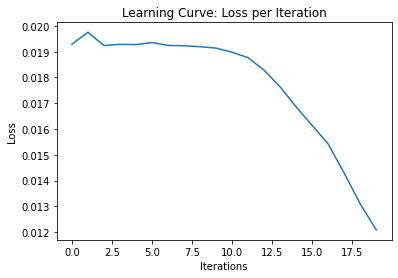

len(cnnc_learning_curve_info): 7
number of parememters cnnc: 644962
=== CNN ===
Epoch 0, Iter 1. [Val Acc 50% (pos: 0%, neg: 100%)] [Train Acc 50% (pos: 0%, neg: 100%), Loss 0.693144]
Epoch 1, Iter 2. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.694984]
Epoch 2, Iter 3. [Val Acc 50% (pos: 100%, neg: 0%)] [Train Acc 50% (pos: 100%, neg: 0%), Loss 0.694810]
Epoch 3, Iter 4. [Val Acc 49% (pos: 0%, neg: 98%)] [Train Acc 56% (pos: 11%, neg: 100%), Loss 0.692776]
Epoch 4, Iter 5. [Val Acc 51% (pos: 100%, neg: 2%)] [Train Acc 64% (pos: 100%, neg: 28%), Loss 0.691003]
Epoch 5, Iter 6. [Val Acc 50% (pos: 0%, neg: 100%)] [Train Acc 50% (pos: 0%, neg: 100%), Loss 0.679859]
Epoch 6, Iter 7. [Val Acc 49% (pos: 86%, neg: 12%)] [Train Acc 61% (pos: 94%, neg: 28%), Loss 0.759866]
Epoch 7, Iter 8. [Val Acc 52% (pos: 100%, neg: 3%)] [Train Acc 61% (pos: 100%, neg: 22%), Loss 0.664751]
Epoch 8, Iter 9. [Val Acc 50% (pos: 36%, neg: 64%)] [Train Acc 58% (pos: 61%, neg: 56%

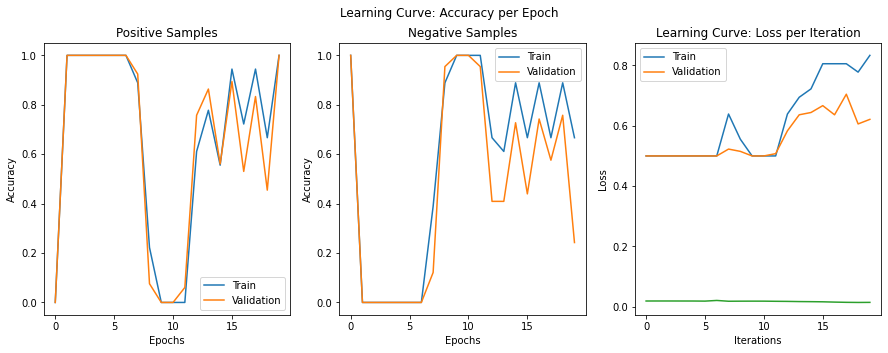

len(cnn_learning_curve_info): 7
number of parememters cnn: 1271862


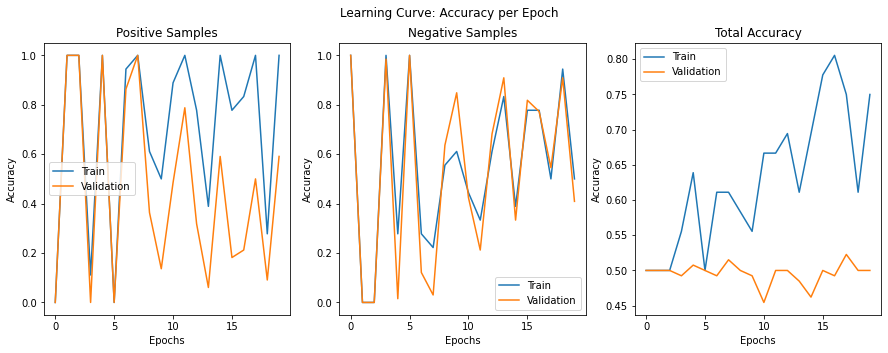

In [28]:
toy_data_size = 6

toy_train_data = train_set[:toy_data_size]
toy_valid_data = valid_set[:toy_data_size]

print("=== CNNChannel ===")
cnnc = CNNChannel()
cnnc_learning_curve_info = train_model(model=cnnc,
                                  train_data=toy_train_data,
                                  validation_data=toy_valid_data,
                                  batch_size=6*toy_data_size,
                                  num_epochs=20,
                                  learning_rate=2e-3,
                                  weight_decay=0,
                                  checkpoint_path=None)
plot_learning_curve(*cnnc_learning_curve_info)
print(f'len(cnnc_learning_curve_info): {len(cnnc_learning_curve_info)}')
print(f'number of parememters cnnc: {get_n_params(cnnc)}')

print("=== CNN ===")
cnn = CNN()
cnn_learning_curve_info = train_model(model=cnn,
                                  train_data=toy_train_data,
                                  validation_data=toy_valid_data,
                                  batch_size=6*toy_data_size,
                                  num_epochs=20,
                                  learning_rate=2e-3,
                                  weight_decay=0,
                                  checkpoint_path=None)

plot_learning_curve(*cnn_learning_curve_info)
print(f'len(cnn_learning_curve_info): {len(cnn_learning_curve_info)}')
print(f'number of parememters cnn: {get_n_params(cnn)}')


### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**
We tried various hyperparameters such as learning rate, batch size, n and kernel size and compared the training results - accuracy and loss. Usually, the model from last learning iteration had the best learning results. We observed that CNNChannel NN has much smaller parameters number - 644,952, compared to CNN - 1,271,862. This difference allowed us to test more hyperparameters options as well as running longer learning.

=== CNNChannel ===
Epoch 0, Iter 8. [Val Acc 58% (pos: 89%, neg: 27%)] [Train Acc 58% (pos: 89%, neg: 27%), Loss 0.691818]
Epoch 1, Iter 16. [Val Acc 58% (pos: 80%, neg: 35%)] [Train Acc 60% (pos: 80%, neg: 41%), Loss 0.678431]
Epoch 2, Iter 24. [Val Acc 57% (pos: 61%, neg: 53%)] [Train Acc 59% (pos: 71%, neg: 48%), Loss 0.639068]
Epoch 3, Iter 32. [Val Acc 73% (pos: 88%, neg: 59%)] [Train Acc 74% (pos: 89%, neg: 59%), Loss 0.609629]
Epoch 4, Iter 40. [Val Acc 76% (pos: 97%, neg: 55%)] [Train Acc 77% (pos: 96%, neg: 58%), Loss 0.445250]
Epoch 5, Iter 48. [Val Acc 81% (pos: 94%, neg: 68%)] [Train Acc 81% (pos: 90%, neg: 72%), Loss 0.543269]
Epoch 6, Iter 56. [Val Acc 83% (pos: 89%, neg: 76%)] [Train Acc 82% (pos: 83%, neg: 81%), Loss 0.393754]
Epoch 7, Iter 64. [Val Acc 86% (pos: 89%, neg: 82%)] [Train Acc 83% (pos: 86%, neg: 80%), Loss 0.492349]
Epoch 8, Iter 72. [Val Acc 86% (pos: 92%, neg: 79%)] [Train Acc 83% (pos: 84%, neg: 82%), Loss 0.405488]
Epoch 9, Iter 80. [Val Acc 88% (pos: 

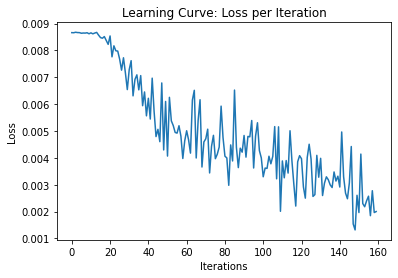

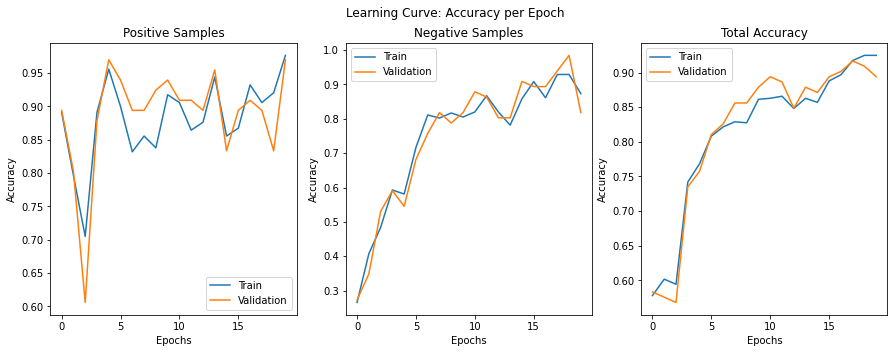

In [14]:
print("=== CNNChannel ===")

cnnC = CNNChannel(n=4, kernel_size=5)
cnnc_learning_curve_info = train_model(model=cnnC,
                                  train_data=train_data,
                                  validation_data=valid_set,
                                  batch_size=80,
                                  num_epochs=20,
                                  learning_rate=1e-3,
                                  weight_decay=0,
                                  checkpoint_path = checkpoint_path)

plot_learning_curve(*cnnc_learning_curve_info)

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

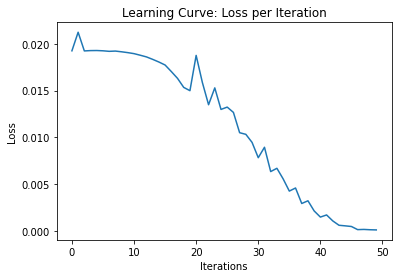

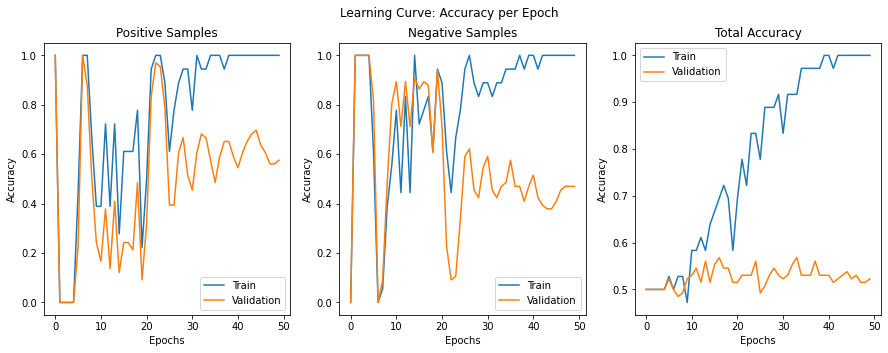

In [15]:
# CNNChannel
plot_learning_curve(*cnn_learning_curve_info)

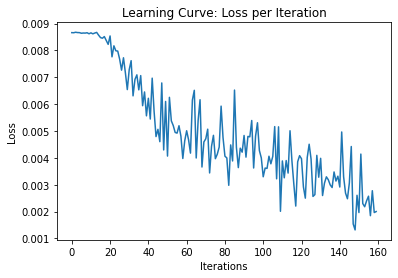

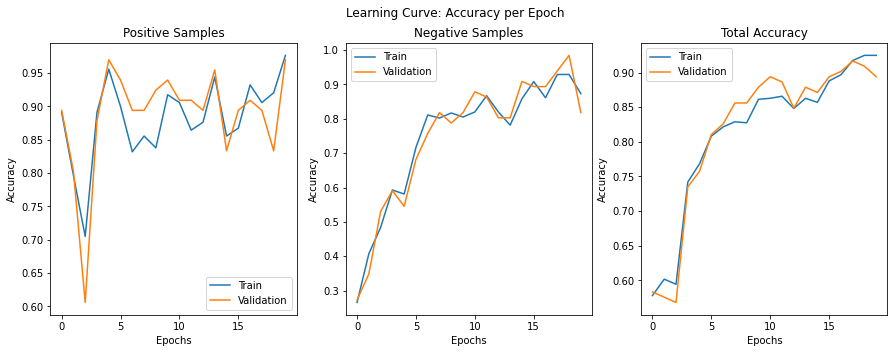

In [16]:
#CNN
plot_learning_curve(*cnnc_learning_curve_info)

As expected (part 2.c), the CNNChannels model performs slightly better than the CNN model, under the same
number of epochs (and iteration i.e., batch size).

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [17]:
# Write your code here. Make sure to include the test accuracy in your report

# load CNNChannel model.
# Model from last learning iteration had the best learning results.
# We use model from iteration 20.
model = CNNChannel()
model.load_state_dict(torch.load(best_model_path))

test_m_acc = get_accuracy(model=model, data=test_m_data, batch_size=100)
test_m_acc = np.array(test_m_acc) * 100
tot_acc_test_m = np.mean(test_m_acc)

test_w_acc =get_accuracy(model=model, data=test_w_data, batch_size=100)
test_w_acc = np.array(test_w_acc) * 100
tot_acc_test_w = np.mean(test_w_acc)

print('Man Shoes   [test_m]: Total accuracy = {:.2f}%, pos accuracy = {:.2f}%, neg accuracy = {:.2f}%'.format(tot_acc_test_m, test_m_acc[0], test_m_acc[1]))
print('Woman Shoes [test_w]: Total accuracy = {:.2f}%, pos accuracy = {:.2f}%, neg accuracy = {:.2f}%'.format(tot_acc_test_w, test_w_acc[0], test_w_acc[1]))

Man Shoes   [test_m]: Total accuracy = 70.00%, pos accuracy = 70.00%, neg accuracy = 70.00%
Woman Shoes [test_w]: Total accuracy = 76.67%, pos accuracy = 70.00%, neg accuracy = 83.33%


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

In [45]:
def get_prediction(model, input):
    """ returns the predicion of a given model
      inspired by the get_accuracy function
    """

    model.eval()
    xs = torch.Tensor(input)
    N, H, W, C = xs.shape
    xs = xs.view(N,C,H,W)
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()[0,0]
    return pred

def get_correct_incorrect_pairs(data, gender):
    same_pair = generate_same_pair(data)
    found_true_positive = False
    found_false_positive = False
    for im in same_pair:
        inp = np.expand_dims(im, 0)
        pred = get_prediction(model, inp)
        if pred == 1 and not found_true_positive:
            found_true_positive = True
            plt.figure()
            plt.title(gender + ' test data CORRECT classification')
            plt.imshow(im + 0.5)
        if pred == 0 and not found_false_positive:
            #found_false_positive = True
            plt.figure()
            plt.title(gender + ' test data INCORRECT classification')
            plt.imshow(im + 0.5)
        if found_true_positive and found_false_positive:
            break

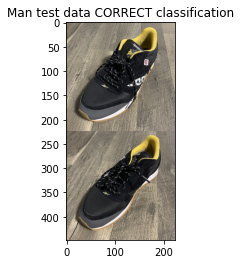

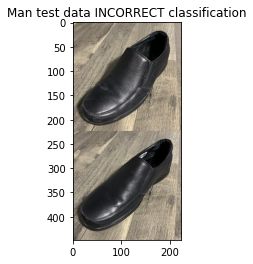

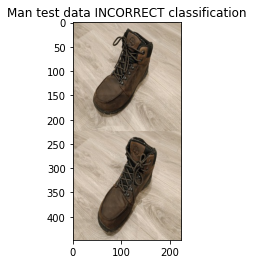

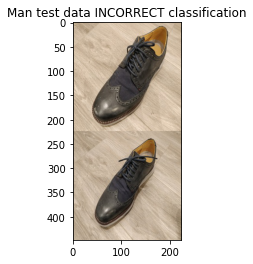

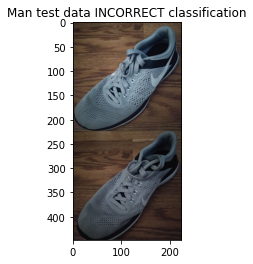

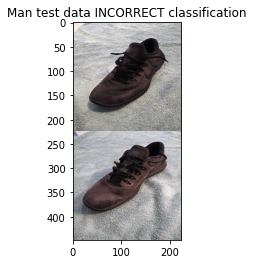

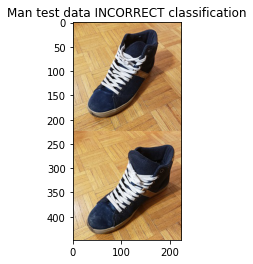

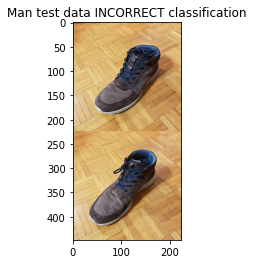

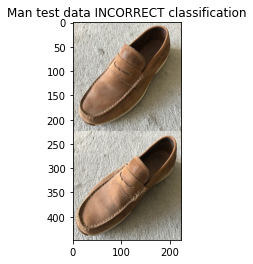

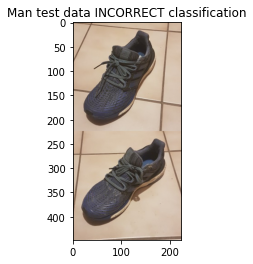

In [46]:
# As we can see from the negative results, our model sometimes makes wrong decisions and recognizes the shoes from the same pair as from different pairs.
# We also see that pair number 4 contains different shoes - probably this is data set issue.
get_correct_incorrect_pairs(test_m_data, 'Man')


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

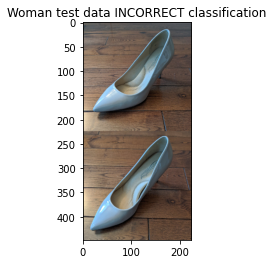

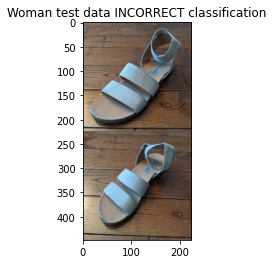

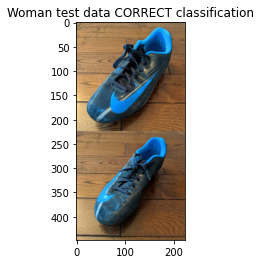

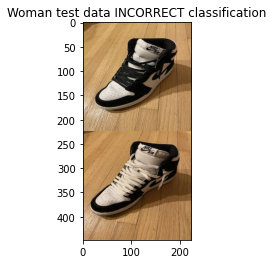

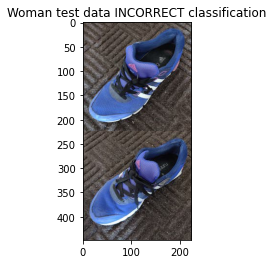

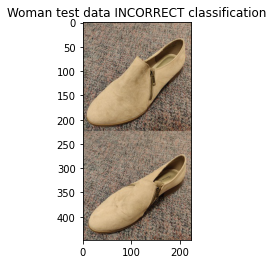

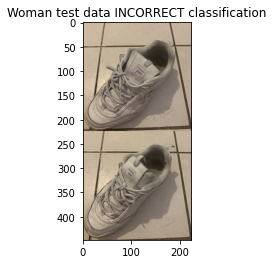

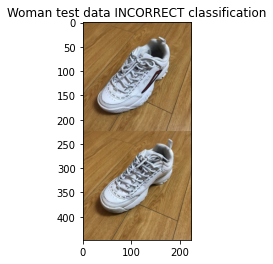

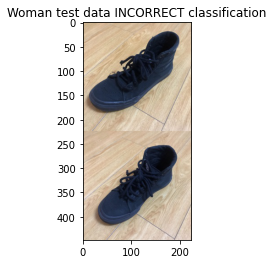

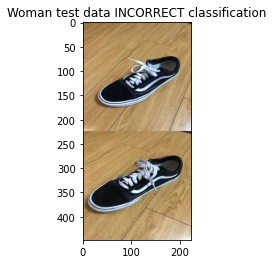

In [47]:
# As we can see from the negative results, our model sometimes makes wrong decisions and recognizes the shoes from the same pair as from different pairs.
# We also see that pair number 4 contains different shoes - probably this is data set issue.
get_correct_incorrect_pairs(test_w_data, 'Woman')

# Automatic PDF Generation and store in GDrive

In [52]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc > /dev/null 2>&1
!pip install pypandoc > /dev/null 2>&1

from google.colab import drive
drive.mount('/content/drive')
!cp 'drive/My Drive/Colab Notebooks/Assignment3_work.ipynb' ./

!jupyter nbconvert --to PDF "Assignment3_work.ipynb" > /dev/null 2>&1
!echo "pdf file generated"
#!ls -la
!cp './Assignment3_work.pdf' 'drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pdf file generated
